projects this weekend
deep learning: https://www.kaggle.com/competitions/playground-series-s5e3/data

# Binary Classification with a Software Defects Dataset

 As someone who writes code that probably leaves a lot to be desired and causes some downstream defects, having an algorithm that's capable of telling me when that's happening and how severe it is seems very cool. With that in mind I chose to do the classification fo defects in software from an old kaggle project [here](https://www.kaggle.com/c/playground-series-s3e23/overview).

The overview is provided as follows:
> **Your Goal**: Predict defects in C programs given various various attributes about the code.

#### The Data

The data was made available as a csv or kaggle dataset. I downloaded the csv and will elaborate on its features below. Kaggle provides a quick overview of their synthetic data as well:
> The dataset for this competition (both train and test) was generated from a deep learning model trained on the Rainfall Prediction using Machine Learning dataset. Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance.

The original data had this to say:
>Data comes from McCabe and Halstead features extractors of
    source code.  These features were defined in the 70s in an attempt
    to objectively characterize code features that are associated with
    software quality.  The nature of association is under dispute.
    Notes on McCabe and Halstead follow.
>
>The McCabe and Halstead measures are "module"-based where a
    "module" is the smallest unit of functionality. In C or Smalltalk,
    "modules" would be called "function" or "method" respectively.

Since I plan to use deep learning, I figured that adding additional data would help with the deep learning models learning more effectively. 

By incorporating the original data, we have an additional 67842 rows to learn from (although it's not particularly novel compared to the synthetic data, so I do not expect huge gains from it.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.keras import layers, Sequential
from sklearn.model_selection import GridSearchCV, train_test_split
import xgboost as xgb

2025-03-01 11:01:09.048424: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740852069.065705    7255 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740852069.070723    7255 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-01 11:01:09.088344: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
filename = "Data/train.csv"
raw_df_1 = pd.read_csv(filename)

In [3]:
print(f"Competition Data is {raw_df_1.shape}")
raw_df_1.head()

Competition Data is (101763, 23)


,id,loc,v(g),ev(g),iv(g),n,v,l,d,i,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,...,17,1,1,0,16.0,9.0,38.0,22.0,5.0,False
1,1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,...,11,0,1,0,11.0,11.0,18.0,14.0,3.0,False
2,2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,...,8,0,1,0,12.0,11.0,28.0,17.0,3.0,False
3,3,8.0,1.0,1.0,1.0,23.0,94.01,0.19,5.25,17.86,...,4,0,2,0,8.0,6.0,16.0,7.0,1.0,True
4,4,11.0,2.0,1.0,2.0,17.0,60.94,0.18,5.63,12.44,...,7,0,2,0,7.0,6.0,10.0,10.0,3.0,False


In [4]:
filename = "Data/jm1.csv"
raw_df_2 = pd.read_csv(filename)

In [5]:
print(f"Original Defect Data is {raw_df_2.shape}")
raw_df_2.head()

Original Defect Data is (10885, 22)


,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,1.1,1.4,1.4,1.4,1.3,1.30,1.30,1.30,1.30,1.30,...,2,2,2,2,1.2,1.2,1.2,1.2,1.4,False
1,1.0,1.0,1.0,1.0,1.0,1.00,1.00,1.00,1.00,1.00,...,1,1,1,1,1,1,1,1,1,True
2,72.0,7.0,1.0,6.0,198.0,1134.13,0.05,20.31,55.85,23029.10,...,51,10,8,1,17,36,112,86,13,True
3,190.0,3.0,1.0,3.0,600.0,4348.76,0.06,17.06,254.87,74202.67,...,129,29,28,2,17,135,329,271,5,True
4,37.0,4.0,1.0,4.0,126.0,599.12,0.06,17.19,34.86,10297.30,...,28,1,6,0,11,16,76,50,7,True


In [6]:
raw_df_1.columns

Index(['id', 'loc', 'v(g)', 'ev(g)', 'iv(g)', 'n', 'v', 'l', 'd', 'i', 'e',
       'b', 't', 'lOCode', 'lOComment', 'lOBlank', 'locCodeAndComment',
       'uniq_Op', 'uniq_Opnd', 'total_Op', 'total_Opnd', 'branchCount',
       'defects'],
      dtype='object')

In [7]:
raw_df_2.columns

Index(['loc', 'v(g)', 'ev(g)', 'iv(g)', 'n', 'v', 'l', 'd', 'i', 'e', 'b', 't',
       'lOCode', 'lOComment', 'lOBlank', 'locCodeAndComment', 'uniq_Op',
       'uniq_Opnd', 'total_Op', 'total_Opnd', 'branchCount', 'defects'],
      dtype='object')

In [8]:
# Clean up column names to match before combining
raw_df_1.drop('id', axis = 1, inplace=True)

In [9]:
# Combine datasets
df = pd.concat([raw_df_1, raw_df_2], axis = 0).reset_index(drop=True)

## Data Cleaning (EDA)

### Data Cleaning

Immediately upon looking at the columns of are data, there are a number of typos and issues occuring. This includes whitespace, duplicate columns, typos, etc. We address each of the formatting issues for the columns below.

In [10]:
print("Columns names are: \n" + str(list(c for c in df.columns)))

Columns names are: 
['loc', 'v(g)', 'ev(g)', 'iv(g)', 'n', 'v', 'l', 'd', 'i', 'e', 'b', 't', 'lOCode', 'lOComment', 'lOBlank', 'locCodeAndComment', 'uniq_Op', 'uniq_Opnd', 'total_Op', 'total_Opnd', 'branchCount', 'defects']


In [11]:
df.head()

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,5448.79,...,17,1,1,0,16.0,9.0,38.0,22.0,5.0,False
1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,936.71,...,11,0,1,0,11.0,11.0,18.0,14.0,3.0,False
2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,1754.01,...,8,0,1,0,12.0,11.0,28.0,17.0,3.0,False
3,8.0,1.0,1.0,1.0,23.0,94.01,0.19,5.25,17.86,473.66,...,4,0,2,0,8.0,6.0,16.0,7.0,1.0,True
4,11.0,2.0,1.0,2.0,17.0,60.94,0.18,5.63,12.44,365.67,...,7,0,2,0,7.0,6.0,10.0,10.0,3.0,False


In [12]:
df.dtypes

loc                  float64
v(g)                 float64
ev(g)                float64
iv(g)                float64
n                    float64
v                    float64
l                    float64
d                    float64
i                    float64
e                    float64
b                    float64
t                    float64
lOCode                 int64
lOComment              int64
lOBlank                int64
locCodeAndComment      int64
uniq_Op               object
uniq_Opnd             object
total_Op              object
total_Opnd            object
branchCount           object
defects                 bool
dtype: object

We can see above that there's some strings that we can reformat as floats, and we can convert the boolean for defects to an integer for learning on. In order to do the conversions, we first want to check for any unexpected values in these columns. We do that below:


In [13]:
def check_for_non_numeric(arr):
    non_numeric_values = set()
    for val in arr:
        if isinstance(val, str):
            try:
                float(val)
            except:
                non_numeric_values.add(val)
        elif not isinstance(val, (int, float, np.number)) or pd.isna(val):
            non_numeric_values.add(val)
    return non_numeric_values

def total_non_numeric(arr):
    non_numeric_values = 0
    for val in arr:
        if isinstance(val, str):
            try:
                float(val)
            except:
                non_numeric_values+= 1
        elif not isinstance(val, (int, float, np.number)) or pd.isna(val):
            non_numeric_values += 1
    return non_numeric_values

for column in df.columns[df.dtypes == 'object']:
    print("Non numeric values in {} are {}".format(
        column, check_for_non_numeric(df[column])))

Non numeric values in uniq_Op are {'?'}
Non numeric values in uniq_Opnd are {'?'}
Non numeric values in total_Op are {'?'}
Non numeric values in total_Opnd are {'?'}
Non numeric values in branchCount are {'?'}


So clearly we need to do something about the ? rows, but we need to figure out the best way to drop them. Arguably the best way would be to use unsupervised learning, cluster the rows based on other parameters, and predict this value based on it's surrounding nodes. Given the focus of this project being on deep learning, I will opt to take a simpler approach.

#### But what do all of these columns mean, do we want them?
Great question friend, lets dig into the original dataset to see what we can find. There's this [handy post](https://www.kaggle.com/competitions/playground-series-s3e23/discussion/444627) that offers a quick summary:

>  1. loc             : numeric % McCabe's line count of code
>  2. v(g)            : numeric % McCabe "cyclomatic complexity"
>  3. ev(g)           : numeric % McCabe "essential complexity"
>  4. iv(g)           : numeric % McCabe "design complexity"
>  5. n               : numeric % Halstead total operators + operands
>  6. v               : numeric % Halstead "volume"
>  7. l               : numeric % Halstead "program length"
>  8. d               : numeric % Halstead "difficulty"
>  9. i               : numeric % Halstead "intelligence"
> 10. e               : numeric % Halstead "effort"
> 11. b               : numeric % Halstead 
> 12. t               : numeric % Halstead's time estimator
> 13. lOCode          : numeric % Halstead's line count
> 14. lOComment       : numeric % Halstead's count of lines of comments
> 15. lOBlank         : numeric % Halstead's count of blank lines
> 16. lOCodeAndComment: numeric
> 17. uniq_Op         : numeric % unique operators
> 18. uniq_Opnd       : numeric % unique operands
> 19. total_Op        : numeric % total operators
> 20. total_Opnd      : numeric % total operands
> 21. branchCount     : numeric % of the flow graph
> 22. defects         : {false,true} % module has/has not one or more  reported defects

Also, the original docs offer in detail explanations of everything [here](https://www.kaggle.com/datasets/semustafacevik/software-defect-prediction) (too big to include in this notebook)

Now that we have some context on the metrics we're trying to solve the missing values for, we can make a more informed choice on replacing them. All of these columns seem meaningful and measure different things, with some correlation. I decided to see how many outliers there were, and since there were so few, I think dropping ends up being the easiest approach

In [14]:
# How many of these ? rows are there
for column in df.columns[df.dtypes == 'object']:
    print("Non numeric values in {} are {}".format(
        column, total_non_numeric(df[column])))

Non numeric values in uniq_Op are 5
Non numeric values in uniq_Opnd are 5
Non numeric values in total_Op are 5
Non numeric values in total_Opnd are 5
Non numeric values in branchCount are 5


In [15]:
# Show rows with this operator, we can see that it's the same 5 rows for each of them.
df[df.uniq_Op == '?'].iloc[:,-6:-1]

,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount
101906,?,?,?,?,?
102121,?,?,?,?,?
103361,?,?,?,?,?
105977,?,?,?,?,?
110042,?,?,?,?,?


In [16]:
# dropping the rows and converting these columns to numeric values as well
df = df[df.uniq_Op != '?']
for column in df.columns[df.dtypes == 'object']:
    df[column] = df[column].astype(np.float64)

In [17]:
# check for Nan's in the numeric columns
(df.isna().values).any()

np.False_

In [18]:
df

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,5448.79,...,17,1,1,0,16.0,9.0,38.0,22.0,5.0,False
1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,936.71,...,11,0,1,0,11.0,11.0,18.0,14.0,3.0,False
2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,1754.01,...,8,0,1,0,12.0,11.0,28.0,17.0,3.0,False
3,8.0,1.0,1.0,1.0,23.0,94.01,0.19,5.25,17.86,473.66,...,4,0,2,0,8.0,6.0,16.0,7.0,1.0,True
4,11.0,2.0,1.0,2.0,17.0,60.94,0.18,5.63,12.44,365.67,...,7,0,2,0,7.0,6.0,10.0,10.0,3.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112643,18.0,4.0,1.0,4.0,52.0,241.48,0.14,7.33,32.93,1770.86,...,13,0,2,0,10.0,15.0,30.0,22.0,7.0,False
112644,9.0,2.0,1.0,2.0,30.0,129.66,0.12,8.25,15.72,1069.68,...,5,0,2,0,12.0,8.0,19.0,11.0,3.0,False
112645,42.0,4.0,1.0,2.0,103.0,519.57,0.04,26.40,19.68,13716.72,...,29,1,10,0,18.0,15.0,59.0,44.0,7.0,False
112646,10.0,1.0,1.0,1.0,36.0,147.15,0.12,8.44,17.44,1241.57,...,6,0,2,0,9.0,8.0,21.0,15.0,1.0,False


In [19]:
df_label = df.defects
df_features = df.drop('defects', axis = 1)

### Correlation

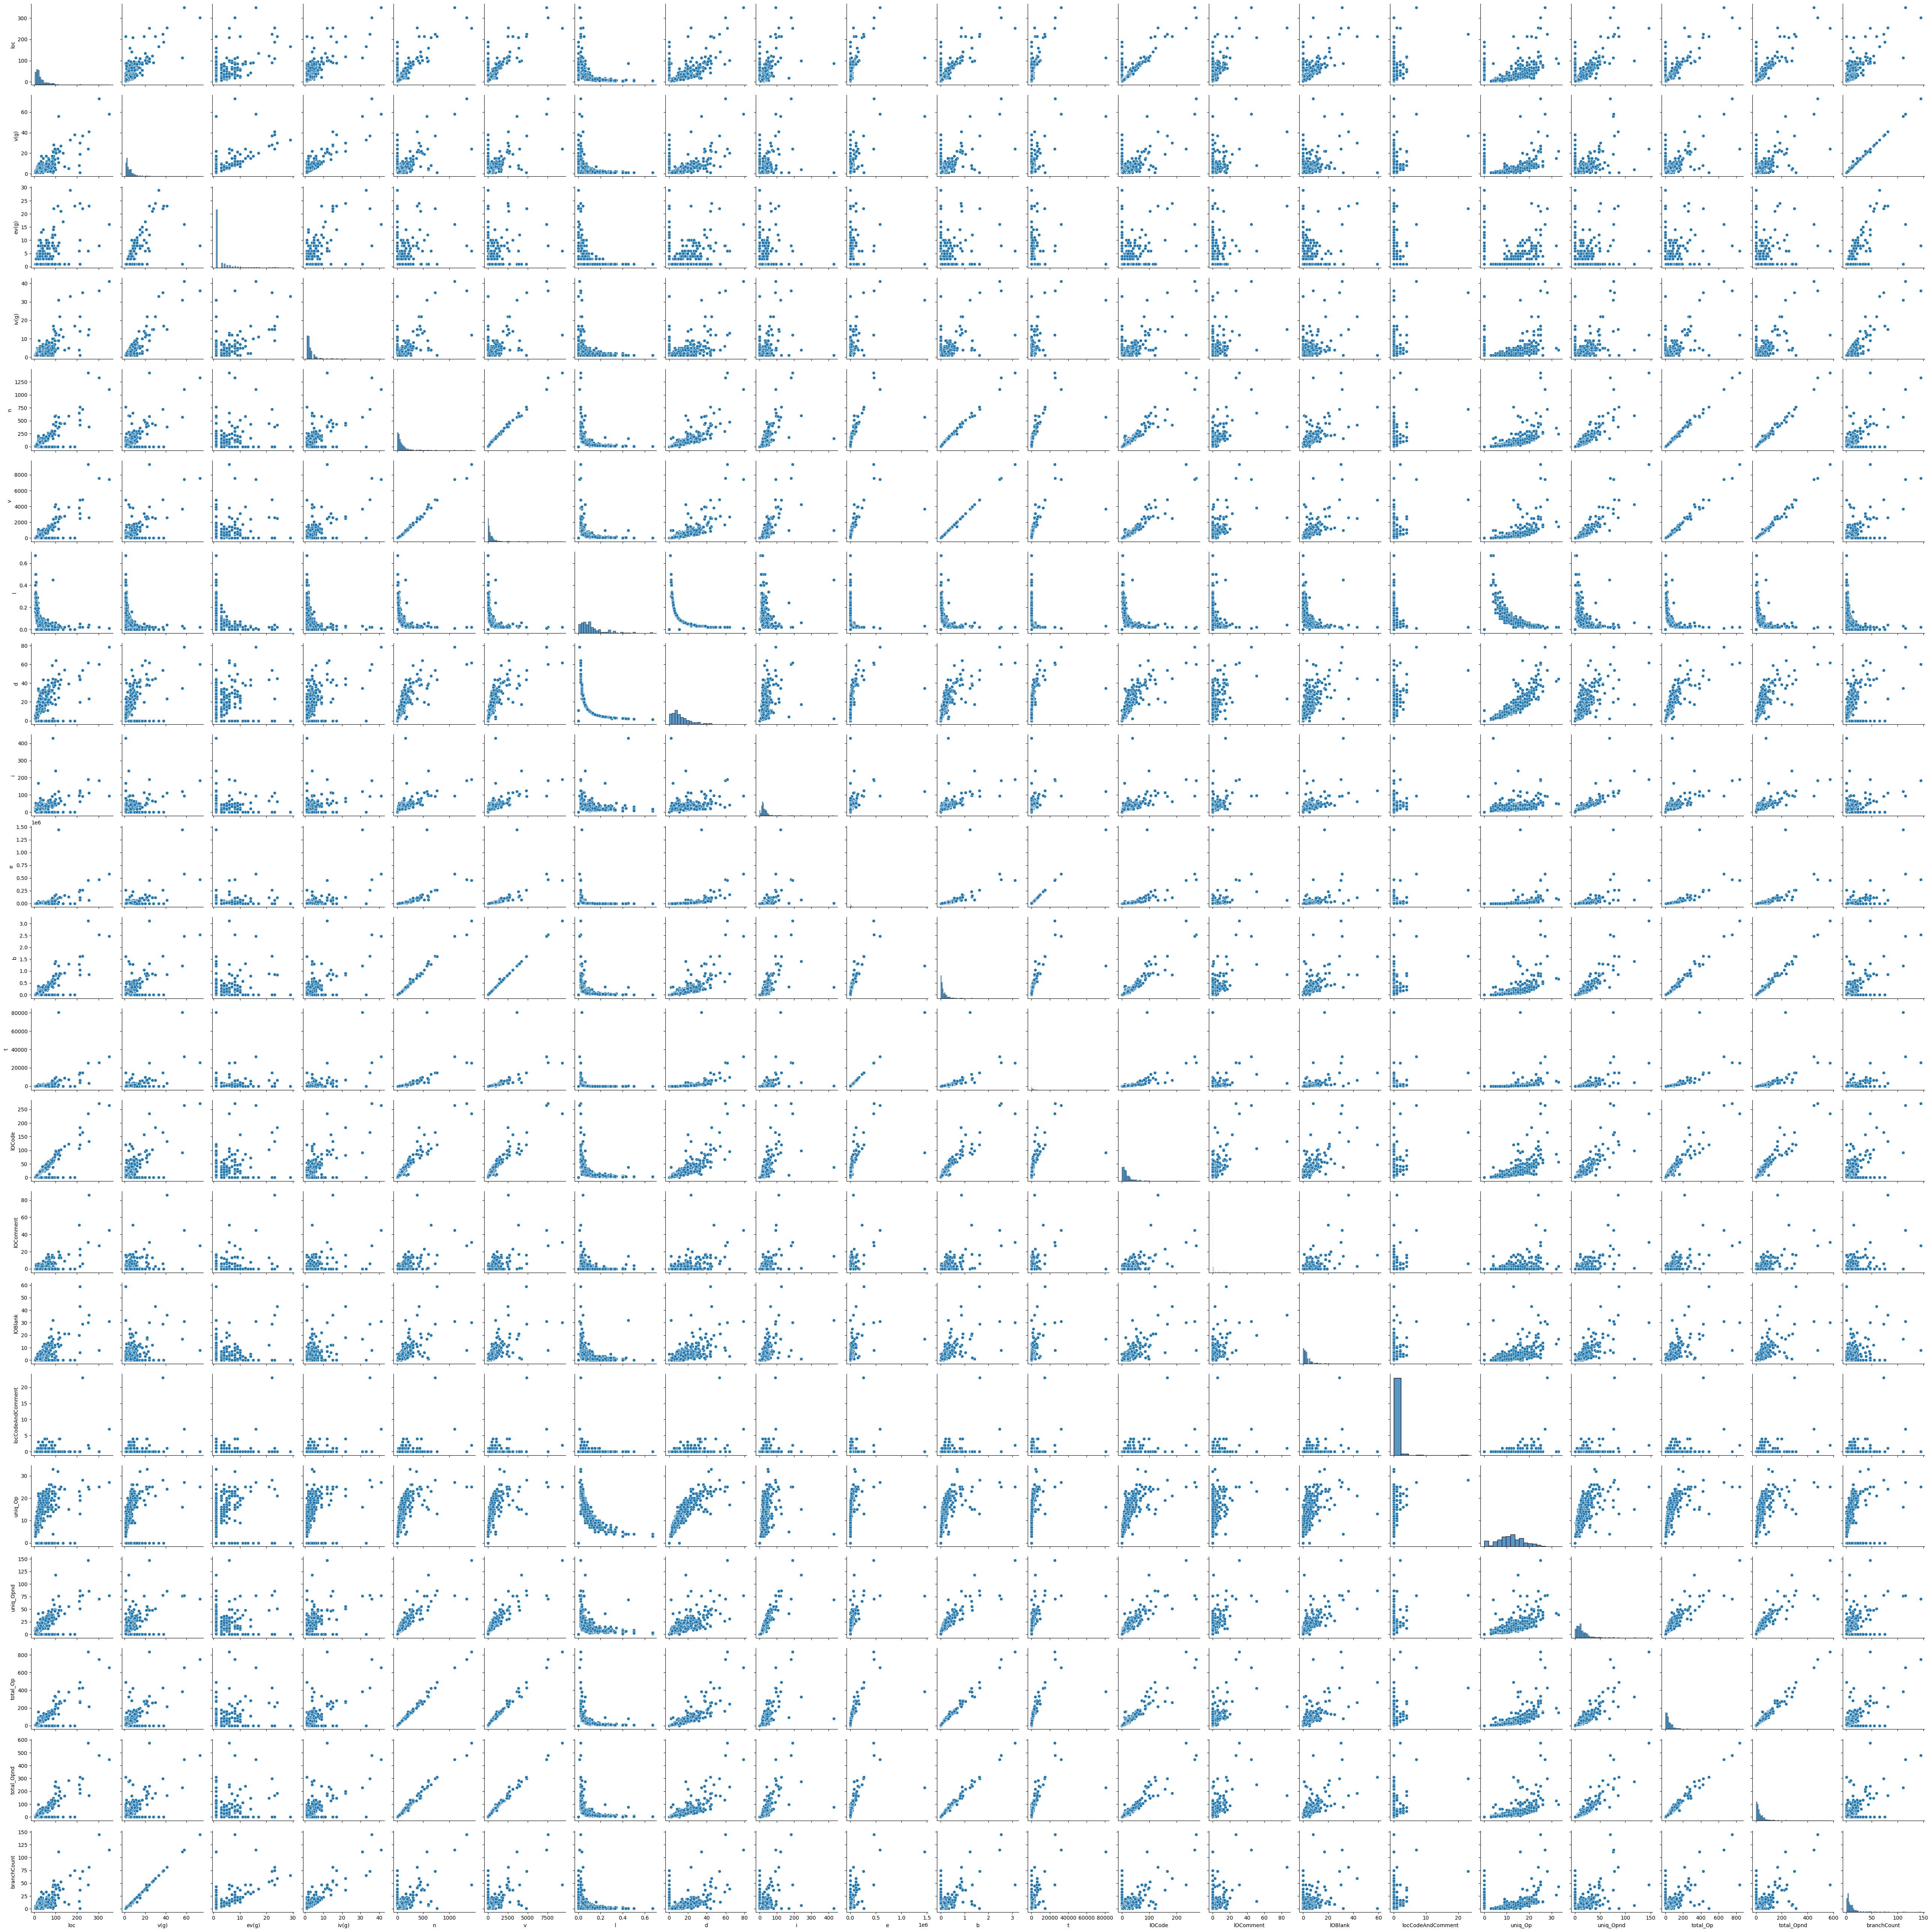

In [20]:
# Create the pairplot, this is tricky because we have so many samples and quite a few features as well
sns.pairplot(df_features.sample(n=500))

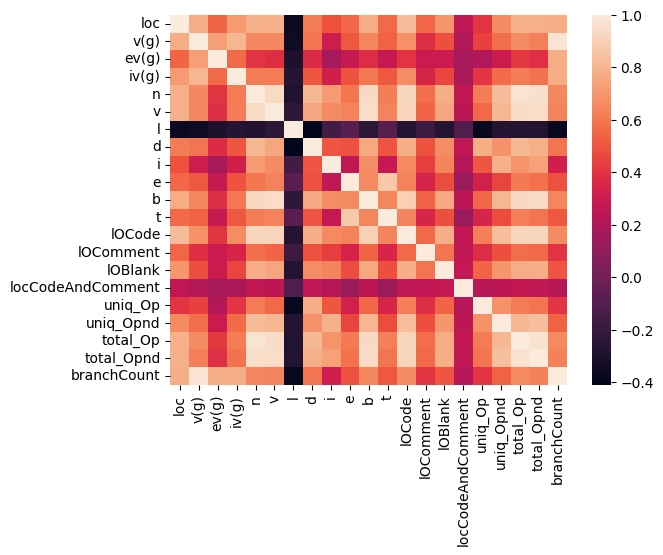

In [21]:
ax = sns.heatmap(df_features.corr(), fmt='.2f')

Unsurprisingly the variable for n, the *Halstead total operators + operands* is highly correlated to the total operands and total operators. We also see high correlation between total branch count and v(g), the *McCabe "cyclomatic complexity."* There's also notable overlap between v and n, the *Halstead "volume"* and *Halstead total operators + operands.* b also has pretty large correlation with total operand metrics, so we'll remove that as well.

I have chosen to drop the simpler metrics, n, v, b, and branchCount as opposed to the others, as I believe that the others are a function of these base metrics, and thus capture more info in less space (similar to how PCA could reduce dimensions).

In [22]:
# dropping highly correlated columns
df_features = df_features.drop(['n', 'v','b', 'branchCount'], axis=1)

### Check for outliers

In [23]:
df_features.describe()

,loc,v(g),ev(g),iv(g),l,d,i,e,t,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd
count,112643.000000,112643.000000,112643.000000,112643.000000,112643.000000,112643.000000,112643.000000,1.126430e+05,1.126430e+05,112643.000000,112643.000000,112643.000000,112643.000000,112643.000000,112643.000000,112643.000000,112643.000000
mean,37.798515,5.575272,2.898630,3.547370,0.113924,13.729737,27.753226,2.239823e+04,1.228830e+03,23.135747,1.867138,4.042186,0.213444,11.826729,15.708248,58.640601,39.939270
std,57.113710,8.534345,4.881992,5.977059,0.107657,14.628378,24.222254,2.259703e+05,1.200908e+04,41.064649,6.276617,6.814420,1.120638,7.137707,19.068320,109.996876,74.969315
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13.000000,2.000000,1.000000,1.000000,0.040000,5.330000,15.305000,5.360400e+02,2.990000e+01,6.000000,0.000000,1.000000,0.000000,8.000000,6.000000,15.000000,9.000000
50%,22.000000,3.000000,1.000000,2.000000,0.080000,9.750000,23.250000,2.237790e+03,1.243300e+02,14.000000,0.000000,2.000000,0.000000,11.000000,12.000000,30.000000,20.000000
75%,42.000000,6.000000,3.000000,4.000000,0.150000,18.130000,34.590000,1.027367e+04,5.695800e+02,26.000000,1.000000,5.000000,0.000000,16.000000,20.000000,67.000000,45.000000
max,3442.000000,470.000000,165.000000,402.000000,1.300000,418.200000,569.780000,3.107978e+07,1.726655e+06,2824.000000,344.000000,447.000000,108.000000,411.000000,1026.000000,5420.000000,3021.000000


There are clearly some outliers in terms of code length and various metrics, this probably corresponds to code files that are much larger and complex. I do not think I need to trim them because they're valid examples and should be considered as well by our network.

### Data Transformation

#### Normalization

In [24]:
normalized_df_features = (df_features-df_features.mean())/df_features.std()

Perform Analysis Using Deep Learning Models of your Choice, Present Discussion, and Conclusions (65 points)

Start the main analysis (the main analysis refers to supervised learning tasks such as classification or regression). Depending on your project, you may have one model or more. Generally, it is deemed a higher quality project if you compare multiple models and show your understanding of why specific models work better than the other or what limitations or cautions specific models may have. For machine learning models, another recommendation is to show enough effort on the hyperparameter optimization.

## Model Building + Training

### Prepare the Data for Learning

In [25]:
features = normalized_df_features.values
labels = df_label.values
dataset = tf.data.Dataset.from_tensor_slices((features, labels))
dataset_size = len(dataset)

BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = dataset_size

# split into three sets for training, validating, and testing
train_size = int(0.7 * dataset_size)  # 70% for training
val_size = int(0.15 * dataset_size)  # 15% for validation
test_size = dataset_size - train_size - val_size #Remaining for test

# shuffle data
dataset = dataset.shuffle(SHUFFLE_BUFFER_SIZE)
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size).take(val_size)
test_dataset = dataset.skip(train_size + val_size)

# batch data
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

I0000 00:00:1740852114.451660    7255 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9057 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:09:00.0, compute capability: 7.5


#### Model Choice
For this project, I believe that a dense neural network will perform very well. The reason I believe this is due to the large amount of data, the lack of a image that would justify a CNN, and there not being sequence data that an RNN is built to handle. Here is my priority list:

1. Dense Neural Network
2. SVM For Comparison

In [26]:
num_of_features = normalized_df_features.shape[1]

### Dense Neural Networks

In [27]:
# first model
model = Sequential([
    layers.InputLayer(shape=(num_of_features,)),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.1),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.1),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.1),
    layers.BatchNormalization(),
    layers.Dense(64),
    layers.LeakyReLU(),
    layers.Dropout(0.1),
    layers.BatchNormalization(),
    layers.Dense(32),
    layers.LeakyReLU(),
    layers.BatchNormalization(),
    layers.Dense(1, activation='sigmoid'),
])
# Test Loss: 0.4506054222583771
# Test Accuracy: 0.8033378720283508
# Test AUC: 0.7414243817329407

In [28]:
# second model, basically identical, too many params, overfits
model = Sequential([
    layers.InputLayer(shape=(num_of_features,)),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.1),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.1),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.1),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.1),
    layers.BatchNormalization(),
    layers.Dense(128),
    layers.LeakyReLU(),
    layers.Dropout(0.1),
    layers.BatchNormalization(),
    layers.Dense(64),
    layers.LeakyReLU(),
    layers.BatchNormalization(),
    layers.Dense(1, activation='sigmoid'),
])
# Test Loss: 0.44812846183776855
# Test Accuracy: 0.802627682685852
# Test AUC: 0.7456364631652832

In [29]:
# third  model, refined
model = Sequential([
    layers.InputLayer(shape=(num_of_features,)),
    layers.Dense(256),
    layers.Dropout(0.1),
    layers.LeakyReLU(),
    layers.BatchNormalization(),
    layers.Dense(256),
    layers.Dropout(0.1),
    layers.LeakyReLU(),
    layers.BatchNormalization(),
    layers.Dense(256),
    layers.Dropout(0.1),
    layers.LeakyReLU(),
    layers.BatchNormalization(),
    layers.Dense(1, activation='sigmoid'),
])

# Test Loss: 0.43750548362731934
# Test Accuracy: 0.8057643175125122
# Test AUC: 0.7841343283653259

In [30]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 256)            │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 139,521 (545.00 KB)

 Trainable params: 137,985 (539.00 KB)

 Non-trainable params: 1,536 (6.00 KB)

In [31]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy', 'auc'])

In [32]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10)

Epoch 1/10


I0000 00:00:1740852117.156474    7388 service.cc:148] XLA service 0x7fe0780122d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740852117.156516    7388 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2025-03-01 11:01:57.199324: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740852117.385547    7388 cuda_dnn.cc:529] Loaded cuDNN version 90300


  65/2465 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5657 - auc: 0.5793 - loss: 0.7983    

I0000 00:00:1740852119.097878    7388 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2465/2465 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.7473 - auc: 0.7077 - loss: 0.5610 - val_accuracy: 0.8090 - val_auc: 0.7780 - val_loss: 0.4378
Epoch 2/10
2465/2465 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.7991 - auc: 0.7555 - loss: 0.4620 - val_accuracy: 0.8038 - val_auc: 0.7749 - val_loss: 0.4473
Epoch 3/10
2465/2465 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8035 - auc: 0.7616 - loss: 0.4517 - val_accuracy: 0.8047 - val_auc: 0.7826 - val_loss: 0.4446
Epoch 4/10
2465/2465 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8016 - auc: 0.7671 - loss: 0.4507 - val_accuracy: 0.8006 - val_auc: 0.7830 - val_loss: 0.4431
Epoch 5/10
2465/2465 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8019 - auc: 0.7662 - loss: 0.4500 - val_accuracy: 0.8029 - val_auc: 0.7821 - val_loss: 0.4429
Epoch 6/10
2465/2465 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8056 - auc: 0.7698 - loss: 0.4431 - val_accuracy: 0.8104 - val_auc: 0.7874 - val_loss: 0.4356
Epoch 7/10
2465/2465 ━━━━━━━━━━━━━━━━━

### Looking at Test and Validation Error Per Epoch

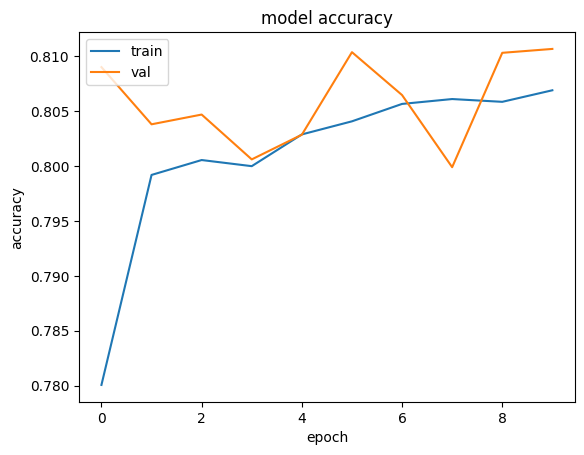

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

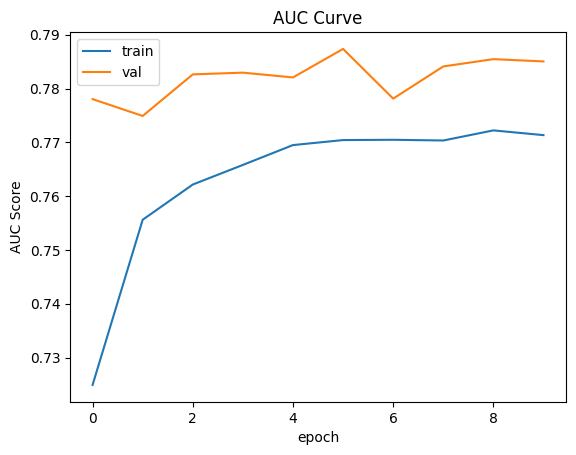

In [34]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('AUC Curve')
plt.ylabel('AUC Score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Predict and Compare to Test

In [35]:
loss, accuracy, auc = model.evaluate(test_dataset)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test AUC: {auc}")

529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8097 - auc: 0.7831 - loss: 0.4350
Test Loss: 0.4344097971916199
Test Accuracy: 0.809907078742981
Test AUC: 0.7871675491333008


In [36]:
# first I need to get my data back in raw format
# this will allow me to feed the features only into model predict
# and then use sklearn to get interesting features

def extract_data_from_dataset(dataset):
    """Extracts features and labels from a TensorFlow Dataset."""
    features = []
    labels = []
    for feature_batch, label_batch in dataset:
        features.append(feature_batch.numpy())
        labels.append(label_batch.numpy())
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels

# Assuming 'test_dataset' is your TensorFlow Dataset
x_test, y_test = extract_data_from_dataset(test_dataset)

2025-03-01 11:03:29.519860: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [37]:
y_predictions_probabilities = model.predict(x_test)

529/529 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


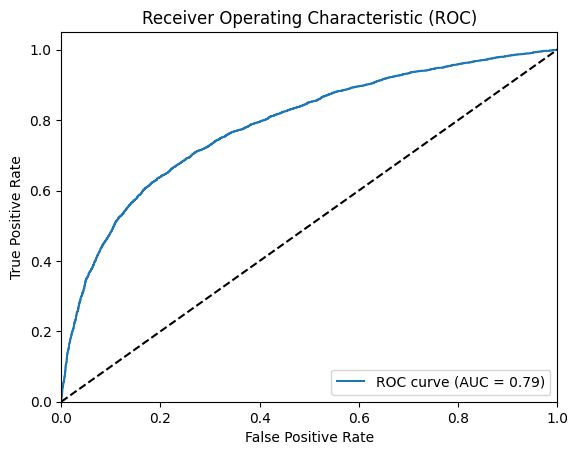

In [38]:
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_predictions_probabilities)
roc_auc = roc_auc_score(y_test, y_predictions_probabilities)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

### SVM

In [39]:
# use features and labels
X_train, X_test, y_train, y_test = train_test_split(features, labels, train_size = 0.8)

In [40]:
parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

clf = xgb.XGBClassifier(tree_method="hist", objective='binary:logistic')

grid_search = GridSearchCV(
    estimator=clf,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10
)

In [41]:
%%time
grid_search.fit(X_train, y_train)

CPU times: user 9.88 s, sys: 648 ms, total: 10.5 s
Wall time: 57.2 s


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=10,
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': range(2, 10),
                         'n_estimators': range(60, 220, 40)},
             scoring='roc_auc')

In [42]:
print(grid_search.best_params_)

{'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 140}


In [43]:
clf_predictions = grid_search.predict_proba(X_test)
clf_predictions = clf_predictions[:,1]

Test Accuracy: 0.7874891908531436
Test AUC: 0.7874891908531436


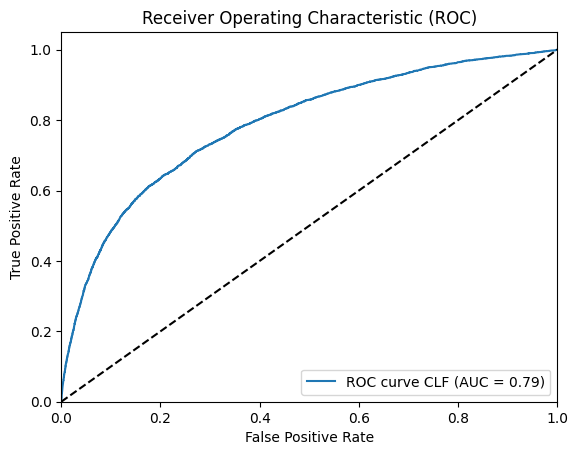

In [44]:
# accuracy score to compare
test_score_clf = grid_search.score(X_test, y_test)
# Calculate ROC curve and AUC
fpr_clf, tpr_clf, thresholds_clf = roc_curve(y_test, clf_predictions)
roc_auc_clf = roc_auc_score(y_test, clf_predictions)

print(f"Test Accuracy: {test_score_clf}")
print(f"Test AUC: {roc_auc_clf}")
# Plot ROC curve
plt.figure()
plt.plot(fpr_clf, tpr_clf, label=f'ROC curve CLF (AUC = {roc_auc_clf:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

## Discussion

We can see from the graph below that our neural network and XGboosted tree perform equally well for classification. I would say that maybe the XGBoost has a slight advantage in the time it takes to setup and train (less messing with architecture).

During the design of the neural network, I found quickly that too many layers was causing overfitting, so adding dropout and reduce the amount of layers + weights was a quick solution that improved training time without sacrificing performance.

With the XGBoost, I decided to use GridSearchCV and the XGBoost api as I haven't messed with XGBoost much up to this point. I think there's experimentation to be done with this algorithm more, as I know it's widely popular for a reason. However, with similar amounts of time invested, either algorithm is a powerful tool and this explains why both are still prevalent.

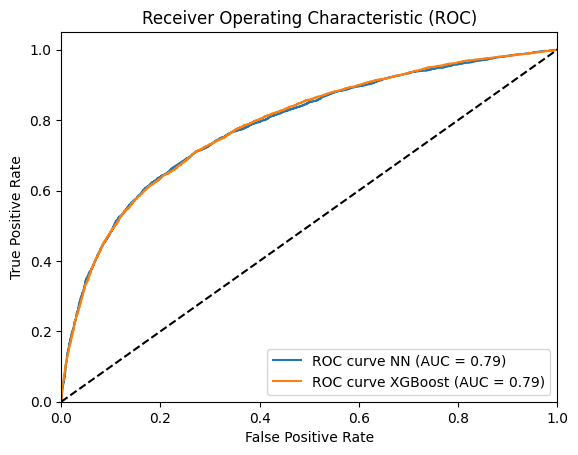

In [45]:
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve NN (AUC = {roc_auc:.2f})')
plt.plot(fpr_clf, tpr_clf, label=f'ROC curve XGBoost (AUC = {roc_auc_clf:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

## Conclusion

Software defects are ubiquitous, and they could quite possibly be amplified as we expand AI's prevalence in this field. It's important to see whether we can help build machines that will prevent or reduce the likelihood of code defects as we move forward. For this project, I set out to see whether easily measured metrics of code could be used to predict the likelihood of coding defects.

I attempted this task with both a deep neural network and an XGBoost ensemble. Both were capable of understanding the relationships in this data. If they were more complex, I think a neural network would've excelled, but since the relationship between excessive operators, cyclomatic complexity, and other metrics to code defects is fairly intuitive (more complexity = higher chance of defect), I think these results are not terrible surprising.

Thanks for Reading!